# **Libraries**

In [1]:
import math
import numpy as np
import pandas as pd
import os
import cv2
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

# **Loading Dataset**

In [2]:
df = pd.read_csv('fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training

# **Display Sample Data**

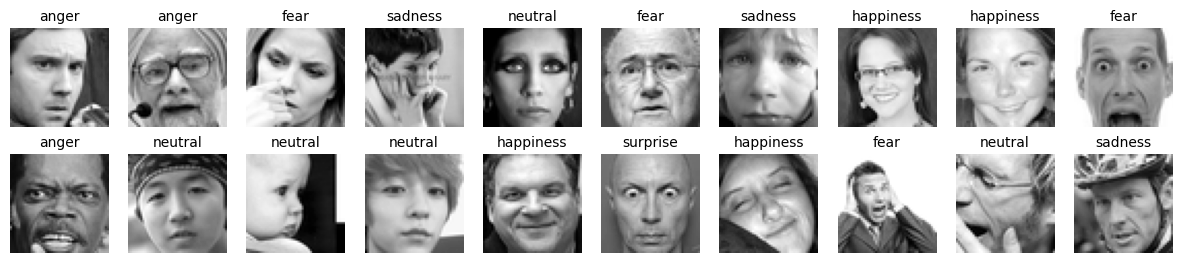

In [3]:
emotion_label={0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

fig = plt.figure(1, (15, 3))
for i in range(20):
    ax = plt.subplot(2, 10, i+1)
    img_pixels=np.reshape(np.array(df.iloc[i,1].split(' ')).astype('float32'),(48,48))
    ax.imshow(img_pixels, cmap='gray')
    ax.set_title(emotion_label[df.iloc[i,0]],fontsize=10)
    plt.axis('off')

# **Pre-Processing**

In [4]:
reshaped_img = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48).astype('float32'))
img_array = np.stack(reshaped_img, axis = 0)
img_array.shape
img_features = []
for i in range(len(img_array)):
    temp = cv2.cvtColor(img_array[i], cv2.COLOR_GRAY2RGB)
    img_features.append(temp)

img_features = np.array(img_features)
print(img_features.shape)

(35887, 48, 48, 3)


# **Label Encoding**

In [5]:
le = LabelEncoder()
img_labels = to_categorical(df.emotion)
img_labels.shape

(35887, 7)

# **Create Training and Validation Set**

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(img_features,
                                                      img_labels,
                                                      shuffle = True,
                                                      stratify = img_labels,
                                                      test_size = 0.1,
                                                      random_state = 41)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((32298, 48, 48, 3), (3589, 48, 48, 3), (32298, 7), (3589, 7))

# **Normalization**

In [7]:
X_train = X_train / 255.
X_valid = X_valid / 255.

# **Creating ResNet50 Model**

In [8]:
# Load the pre-trained ResNet50 model
resnet = ResNet50(weights='imagenet',
                 include_top = False,
                 input_shape = (48, 48, 3))


for layer in resnet.layers:
    layer.trainable = True

resnet.summary()

94765736/94765736 [==============================] - 3s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 48, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 54, 54, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 24, 24, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 24, 24, 64)           256       ['conv1_conv[0][0]']          
 on)                      

# **Transfer Learning**
 Custom Feature Extraction Head with Global Average Pooling and Dense Layer

In [9]:
def Head_Layers(target_model, classes):
    model = target_model.layers[-2].output
    model = GlobalAveragePooling2D()(model)
    model = Dense(classes, activation = 'softmax', name = 'out_layer')(model)

    return model

# create our specific model
num_classes = y_train.shape[1]
hl = Head_Layers(resnet, num_classes)
model = Model(inputs = resnet.input, outputs = hl)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 48, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 54, 54, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 24, 24, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 24, 24, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

# **Callbacks**
Callbacks have been specified to be called at certain points during the training process of the neural network. These callback functions are used to perform actions at specific events, such as the end of an epoch, before or after a batch, or when the model reaches a certain performance threshold.

In [10]:
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                               min_delta = 0.00005,
                               patience = 11,
                               verbose = 1,
                               restore_best_weights = True,)

lr_scheduler = ReduceLROnPlateau(monitor = 'val_accuracy',
                                 factor = 0.5,
                                 patience = 7,
                                 min_lr = 1e-7,
                                 verbose = 1,)

callbacks = [early_stopping,lr_scheduler,]

# **Data Augmentation**
The goal is to expose the model to a wider range of variations in the input data, helping the model generalize better to unseen examples, since our available labeled data is limited.

In [11]:
data_generator = ImageDataGenerator(rotation_range = 15,
                                   width_shift_range = 0.15,
                                   height_shift_range = 0.15,
                                   shear_range = 0.15,
                                   zoom_range = 0.15,
                                   horizontal_flip = True,)
data_generator.fit(X_train)

# **Optimizer**
For this model we use SGD optimizer with Learning of 0.001.

In [12]:
optimizer = optimizers.SGD(learning_rate=0.001,momentum=0.9,nesterov=True)


# **Compile**

In [13]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizer,
              metrics = ['accuracy'])

# Plot the Model

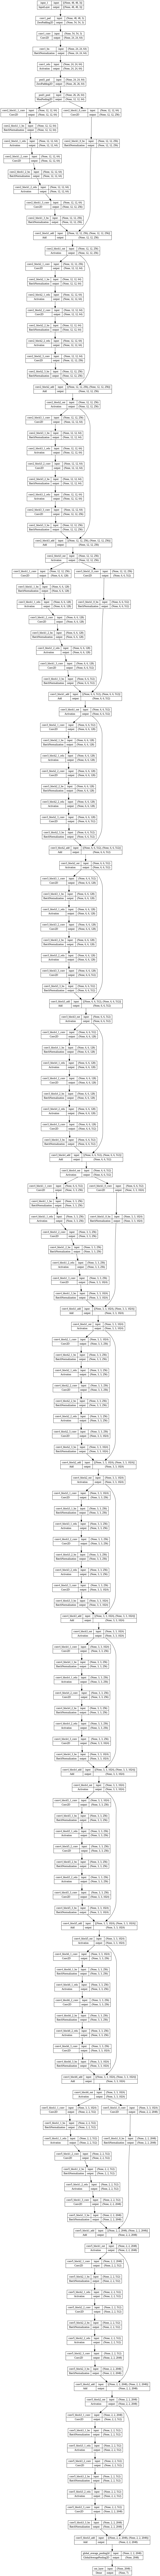

In [14]:
model_plot = 'model_2.png'
tf.keras.utils.plot_model(model, to_file=model_plot, show_shapes=True)

# **Train the Model**

In [15]:
batch_size = 32
epochs = 50

history = model.fit(data_generator.flow(X_train,
                                        y_train,
                                        batch_size = batch_size),
                                        validation_data = (X_valid, y_valid),
                                        steps_per_epoch = len(X_train) / batch_size,
                                        epochs = epochs,
                                        callbacks = callbacks,
                                        use_multiprocessing = True)

Epoch 1/50
1009/1009 [==============================] - 108s 81ms/step - loss: 2.1467 - accuracy: 0.3174 - val_loss: 1.5909 - val_accuracy: 0.4263 - lr: 0.0010
Epoch 2/50
1009/1009 [==============================] - 79s 78ms/step - loss: 1.5291 - accuracy: 0.4380 - val_loss: 1.3748 - val_accuracy: 0.4996 - lr: 0.0010
Epoch 3/50
1009/1009 [==============================] - 77s 76ms/step - loss: 1.3976 - accuracy: 0.4805 - val_loss: 1.4290 - val_accuracy: 0.4854 - lr: 0.0010
Epoch 4/50
1009/1009 [==============================] - 78s 77ms/step - loss: 1.3178 - accuracy: 0.5112 - val_loss: 1.1824 - val_accuracy: 0.5539 - lr: 0.0010
Epoch 5/50
1009/1009 [==============================] - 77s 76ms/step - loss: 1.2628 - accuracy: 0.5310 - val_loss: 1.2255 - val_accuracy: 0.5731 - lr: 0.0010
Epoch 6/50
1009/1009 [==============================] - 77s 76ms/step - loss: 1.2099 - accuracy: 0.5496 - val_loss: 1.1523 - val_accuracy: 0.5723 - lr: 0.0010
Epoch 7/50
1009/1009 [=======================

In [16]:
model_yaml = model.to_json()
with open("model_2.yaml", "w") as yaml_file:
     yaml_file.write(model_yaml)
model.save("mode_2.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **Validation Accuracy and Loss Plot**

In [17]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.savefig('epoch_history_dcnn.png')
plt.show()

# **Confusion Matrix**

In [18]:
import sklearn as sk
ypred_valid = np.argmax(model.predict(X_valid), axis=1)
ymax_valid=np.argmax(y_valid, axis=1)

print(sk.metrics.accuracy_score(ymax_valid, ypred_valid))
print(sk.metrics.confusion_matrix(ymax_valid, ypred_valid))
print(sk.metrics.classification_report(ymax_valid, ypred_valid))

113/113 [==============================] - 5s 12ms/step
0.6383393702981331
[[266  10  45  13  87   9  65]
 [  5  43   1   1   2   0   3]
 [ 57   4 239  12  95  45  60]
 [ 33   1  34 710  34  22  65]
 [ 66   8  77  13 347   8  89]
 [ 11   1  47  19   7 297  18]
 [ 43   1  22  37 111  17 389]]
              precision    recall  f1-score   support

           0       0.55      0.54      0.55       495
           1       0.63      0.78      0.70        55
           2       0.51      0.47      0.49       512
           3       0.88      0.79      0.83       899
           4       0.51      0.57      0.54       608
           5       0.75      0.74      0.74       400
           6       0.56      0.63      0.59       620

    accuracy                           0.64      3589
   macro avg       0.63      0.65      0.63      3589
weighted avg       0.65      0.64      0.64      3589

